In [11]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import humanfriendly
from IPython.display import display
from loguru import logger as LOG
import tqdm
import time

In [5]:
mpl.rc('figure', facecolor='white')
print(mpl.rcParams['figure.facecolor'])

white


In [34]:
pd.options.display.max_rows = 100

In [6]:
def display_df_info(df, name=None):
    print(f'{name or ""} {len(df)} rows')
    columns = []
    for col in df.columns:
        info = {
            'column': col, 
            'dtype': df[col].dtype,
            'memory_usage': humanfriendly.format_size(df[col].nbytes),
            'num_unique': df[col].nunique(),
            'num_null': df[col].isnull().sum(),
        }
        try:
            info['min'] = df[col].min()
            info['max'] = df[col].max()
        except (TypeError, ValueError):
            cnts = df[col].value_counts()
            info['min'] = cnts.idxmin()
            info['max'] = cnts.idxmax()
        columns.append(info)
    info = pd.DataFrame.from_records(columns)
    display(info)

In [5]:
df_offline = pd.read_msgpack('data/z1_raw_offline.msgpack')
df_online_coupon = pd.read_msgpack('data/z1_raw_online_coupon.msgpack')
df_online_click = pd.read_msgpack('data/z1_raw_online_click.msgpack')

In [253]:
display_df_info(df_offline)
display_df_info(df_online_coupon)
display_df_info(df_online_click)

 1754884 rows


,column,dtype,max,memory_usage,min,num_null,num_unique
0,user_id,int64,7361032,14.04 MB,4,0,539438
1,merchant_id,int64,8856,14.04 MB,1,0,8415
2,coupon_id,object,7610,14.04 MB,10779,701602,9738
3,distance,float64,10,14.04 MB,0,106003,11
4,date_received,datetime64[ns],2016-06-15 00:00:00,14.04 MB,2016-01-01 00:00:00,701602,167
5,date,datetime64[ns],2016-06-30 00:00:00,14.04 MB,2016-01-01 00:00:00,977900,182
6,discount_name,object,30:5,14.04 MB,150:5,701602,45
7,is_dazhe,bool,True,1.75 MB,False,0,2
8,is_manjian,bool,True,1.75 MB,False,0,2
9,discount_man,float64,300,14.04 MB,0,701602,10


 2028046 rows


,column,dtype,max,memory_usage,min,num_null,num_unique
0,user_id,int64,15499999,16.22 MB,4,0,482945
1,merchant_id,int64,60000,16.22 MB,10001,0,7963
2,coupon_id,object,fixed,16.22 MB,100151025,1155689,27747
3,date_received,datetime64[ns],2016-06-15 00:00:00,16.22 MB,2016-01-01 00:00:00,1155689,167
4,date,datetime64[ns],2016-06-30 00:00:00,16.22 MB,2016-01-01 00:00:00,655898,182
5,discount_name,object,fixed,16.22 MB,800:500,1155689,64
6,is_xianshi,bool,True,2.03 MB,False,0,2
7,is_dazhe,bool,False,2.03 MB,False,0,1
8,is_manjian,bool,True,2.03 MB,False,0,2
9,discount_man,float64,1000,16.22 MB,5,1287235,12


 4380240 rows


,column,dtype,max,memory_usage,min,num_null,num_unique
0,user_id,int64,15500000,35.04 MB,36,0,585710
1,merchant_id,int64,60000,35.04 MB,10001,0,7999
2,date,datetime64[ns],2016-06-30 00:00:00,35.04 MB,2016-01-01 00:00:00,0,182
3,count,int64,630,35.04 MB,1,0,232


In [22]:
df_raw_offline = pd.read_msgpack('data/z1_raw_offline.msgpack')
df_raw_test = pd.read_msgpack('data/z1_raw_test.msgpack')
df_user = pd.read_msgpack('data/z6_ts_feature_user.msgpack')
df_merchant = pd.read_msgpack('data/z6_ts_feature_merchant.msgpack')
df_coupon = pd.read_msgpack('data/z6_ts_feature_coupon.msgpack')
df_user_merchant = pd.read_msgpack('data/z6_ts_feature_user_merchant.msgpack')
df_events = df = pd.read_msgpack('data/z6_ts_events.msgpack')
df_train_full = pd.read_msgpack('data/z6_ts_merged_train_full.msgpack')
df_train = pd.read_msgpack('data/z6_ts_merged_train.msgpack')
df_test_full = pd.read_msgpack('data/z6_ts_merged_test_full.msgpack')
df_test = pd.read_msgpack('data/z6_ts_merged_test.msgpack')

In [144]:
g = df.groupby(level=['user_id', 'date'], sort=False)
x = g.get_group((2488, '2016-01-01'))
x.loc[idx[2488, :'2016-01-01'],]

,,date2,event_type,merchant_id,coupon_id,discount_name,distance,click_count
user_id,date,,,,,,,
2488,2016-01-01,NaT,offline_buy_without_coupon,4833,NaN,NaN,8.0,NaN


In [151]:
df = df_events.head(1000).set_index(['user_id', 'date']).sort_index()

DAY_1 = pd.Timedelta(days=1)
DAY_15 = pd.Timedelta(days=15)
DAY_75 = pd.Timedelta(days=75)
DAY_76 = pd.Timedelta(days=76)

In [152]:
%%time

idx = pd.IndexSlice


def myfunc(x):
    user_id, date = x.name
    yesterday = df.loc[idx[user_id, date - DAY_1 : date - DAY_1],]
    future = df.loc[idx[user_id, date + DAY_1 : date + DAY_15],]
    recent = df.loc[idx[user_id, date - DAY_75 : date - DAY_15],]
    history = df.loc[idx[user_id, : (date - DAY_76)],]
    return [x, future, yesterday, recent, history]
    
result = df.groupby(level=['user_id', 'date'], sort=False).apply(myfunc)
len(result)

CPU times: user 8.32 s, sys: 69.7 ms, total: 8.39 s
Wall time: 8.45 s


In [207]:
data = [pd.Series([1,i]) for i in range(1000)]

In [215]:
%%timeit
n = 0
for s in data:
    for x in s:
        n += x
n

11.8 ms ± 232 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [214]:
%%timeit
n = 0
for s in data:
    n += s.sum()
n

68 ms ± 2.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [235]:

def build_date_ranges():
    d = pd.date_range('2016-01-01', '2016-07-31', freq='D')
    ret = {'date': d}
    ret['yesterday'] = d - pd.Timedelta(days=1)
    ret['future_begin'] = d + pd.Timedelta(days=1)
    ret['future_end'] = d + pd.Timedelta(days=15)
    ret['recent_end'] = d - pd.Timedelta(days=15)
    ret['recent_begin'] = d - pd.Timedelta(days=74)
    ret['history_end'] = d - pd.Timedelta(days=75)
    df = pd.DataFrame(ret).set_index('date')
    return dict([(k, tuple(v)) for k, v in df.iterrows()])


DATE_RANGES = build_date_ranges()
simple_dict = {i:[0,1,2,3,4,5] for i in range(300)}
key = pd.Timestamp('2016-01-01')

a = np.arange(1)
df = pd.DataFrame(a, columns=['a'])

In [236]:
%%timeit
df.rolling(3).sum().dropna()

1.69 ms ± 26.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [238]:
%%timeit
df.rolling(3).apply(lambda x: sum(x)).dropna()

/Users/kk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


1.74 ms ± 17.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [175]:
idx = pd.IndexSlice

result = []
g = df.groupby(level=['user_id', 'date'])

print('start')
for i, ((user_id, date), x) in enumerate(g):
    if i % 1000 == 0:
        print(i, user_id, date)
    yesterday = df.loc[idx[user_id, date - DAY_1 : date - DAY_1],]
    future = df.loc[idx[user_id, date + DAY_1 : date + DAY_15],]
    recent = df.loc[idx[user_id, date - DAY_75 : date - DAY_15],]
    history = df.loc[idx[user_id, : (date - DAY_76)],]
    result.append([user_id, date, x, future, yesterday, recent, history])

result = pd.DataFrame(result, columns=['user_id', 'date', 'today', 'yesterday', 'future', 'recent', 'history'])
result

start
0 4 2016-02-14 00:00:00



KeyboardInterrupt



In [162]:
columns = ['user_id', 'date', 'today', 'yesterday', 'future', 'recent', 'history']
result_dict = {}
for row in 

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     0
40     0
41     0
42     0
43     0
44     0
45     0
46     0
47     0
48     0
49     0
      ..
939    0
940    0
941    0
942    0
943    0
944    0
945    0
946    0
947    0
948    0
949    0
950    0
951    0
952    0
953    0
954    0
955    0
956    0
957    0
958    0
959    0
960    0
961    0
962    0
963    0
964    0
965    0
966    0
967    0
968    0
969    0
970    0
971    0
972    0
973    0
974    0
975    0
976    0
977    0
978    0
979    0
980    0
981    0
982    0
983    0
984    0
985    0
986    0
987    0
988    0
Name: recent, Length: 989, dtype: int64

In [56]:
# 未来15天领了多少张券，及最短时间间隔
# 未来15天领了多少张同商家的券，及最短时间间隔
# 未来15天领了多少张相同的券，及最短时间间隔
# 未来15天领了多少个不同商家
# 未来15天领了多少种券
# 未来15天商家被领取的优惠券数目
# 未来15天商家被领取的相同优惠券数目
# 未来15天商家被多少不同用户领取的数目
# 未来15天商家发行的所有优惠券种类数目
df = df_events[df_events.date >= '2016-07-01']
df.groupby(['user_id', 'date']).apply(lambda df: len(df[df.date]))

,date,date2,event_type,user_id,merchant_id,coupon_id,discount_name,distance,click_count
3344804,2016-07-01,NaT,offline_receive_coupon,3649795,5717,10418,30:5,0.0,NaN
3344848,2016-07-01,NaT,offline_receive_coupon,2324743,5717,10418,30:5,0.0,NaN
3344868,2016-07-01,NaT,offline_receive_coupon,3025159,2050,10438,200:20,3.0,NaN
3344956,2016-07-01,NaT,offline_receive_coupon,6992410,7613,1971,5:1,NaN,NaN
3344982,2016-07-01,NaT,offline_receive_coupon,3048205,5717,10418,30:5,1.0,NaN
3344992,2016-07-01,NaT,offline_receive_coupon,3639055,450,9983,30:5,3.0,NaN
3345064,2016-07-01,NaT,offline_receive_coupon,2870035,5717,10418,30:5,2.0,NaN
3345065,2016-07-01,NaT,offline_receive_coupon,2870035,3621,2978,20:5,2.0,NaN
3345075,2016-07-01,NaT,offline_receive_coupon,2146579,7903,8137,20:1,0.0,NaN
3345085,2016-07-01,NaT,offline_receive_coupon,4349482,5138,8059,50:10,4.0,NaN


In [29]:
df_train['date'].dt.dayofweek.value_counts().sort_index()

0          4
1          4
2          4
3          4
4          4
5          4
6          4
7          4
8          4
9          4
10         4
11         4
12         4
13         4
14         4
15         4
16         4
17         4
18         4
19         4
20         4
21         4
22         4
23         4
24         4
25         4
26         4
27         4
28         4
29         4
          ..
1053252    2
1053253    2
1053254    2
1053255    2
1053256    2
1053257    2
1053258    2
1053259    2
1053260    2
1053261    2
1053262    2
1053263    2
1053264    2
1053265    2
1053266    2
1053267    2
1053268    2
1053269    2
1053270    2
1053271    2
1053272    2
1053273    2
1053274    2
1053275    2
1053276    2
1053277    2
1053278    2
1053279    2
1053280    2
1053281    2
Name: date, Length: 1053282, dtype: int64

In [53]:
df_wepe_submit = pd.read_csv(
    '/Users/kk/myjupyter/O2O-Coupon-Usage-Forecast/code/wepon/season one/xgb_valid_preds.csv', 
    header=None, 
    names=['user_id', 'coupon_id', 'date', 'label', 'prob'])
df_wepe_submit['label'] = df_wepe_submit['label'].astype(bool)
df_wepe_submit.head(5)

,user_id,coupon_id,date,label,prob
0,5555255,1,20160530,False,0.331406
1,2266597,1,20160603,False,0.406412
2,3057133,1,20160606,False,0.456243
3,472146,1,20160522,True,0.521137
4,4639252,3,20160527,False,0.308279


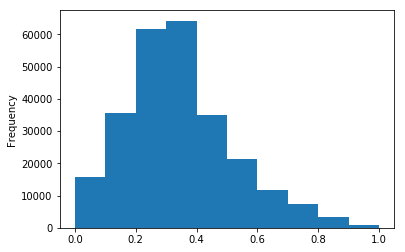

In [55]:
df_wepe_submit['prob'].plot(kind='hist')

In [48]:
df_train_submit = pd.read_csv(
    'data/submit-lgb-train-20190111-082959.csv', 
    header=None, 
    names=['user_id', 'coupon_id', 'date', 'label', 'prob'])
df_train_submit.head(5)

,user_id,coupon_id,date,label,prob
0,3916664,2663,20160101,False,0.616768
1,124779,7496,20160101,False,0.717824
2,2273636,9704,20160101,False,0.388933
3,6001356,1895,20160101,False,0.615731
4,1340099,4186,20160101,False,0.717824


In [49]:
df_validate_submit = pd.read_csv(
    'data/submit-lgb-validate-20190111-082959.csv', 
    header=None,
    names=['user_id', 'coupon_id', 'date', 'label', 'prob'])
df_validate_submit.head(5)

,user_id,coupon_id,date,label,prob
0,6950628,13929,20160501,False,0.747823
1,6403812,4846,20160501,False,0.528032
2,4314852,6387,20160501,False,0.337363
3,4906728,13423,20160501,False,0.246763
4,5201640,8952,20160501,False,0.307897


In [50]:
df_submit = pd.read_csv(
    'data/submit-lgb-20190111-082959.csv', 
    header=None, 
    names=['user_id', 'coupon_id', 'date', 'prob'])
df_submit.head(5)

,user_id,coupon_id,date,prob
0,3649795,10418,20160701,0.551372
1,2324743,10418,20160701,0.547599
2,3025159,10438,20160701,0.078216
3,6992410,1971,20160701,0.607054
4,3048205,10418,20160701,0.443578


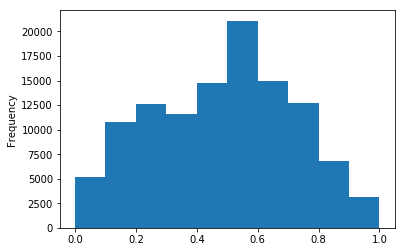

In [51]:
df_submit['prob'].plot(kind='hist')

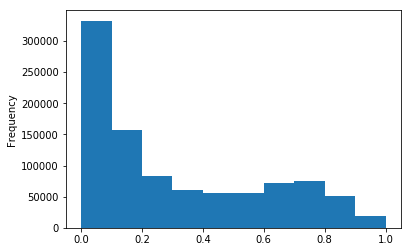

In [52]:
df_train_submit['prob'].plot(kind='hist')

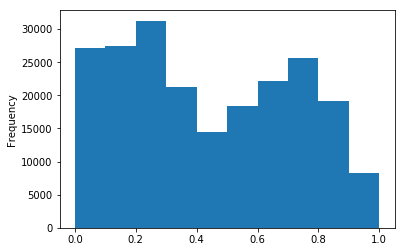

In [53]:
df_validate_submit['prob'].plot(kind='hist')

In [41]:
df = df_validate_submit.groupby('coupon_id').size()
df.quantile([0.5, 0.9, 0.99])

0.50      6.0
0.90     37.0
0.99    390.8
dtype: float64

In [42]:
df = df_submit.groupby('coupon_id').size()
df.quantile([0.5, 0.9, 0.99])

0.50      7.00
0.90     41.00
0.99    334.65
dtype: float64

In [23]:
df_submit_coupon_id_count = df_validate_submit.groupby('coupon_id').size().sort_values().to_frame('count')
len(df_submit_coupon_id_count), len(df_submit_coupon_id_count[df_submit_coupon_id_count['count']<=6])

(6241, 3145)

In [29]:
coupon_ids_3 = df_submit_coupon_id_count[df_submit_coupon_id_count['count']>40].index
len(coupon_ids_3)

569

In [55]:
from sklearn.metrics import roc_auc_score

def coupon_auc(df):
    try:
        return roc_auc_score(df['label'], df['prob'])
    except ValueError:
        return None

coupon_auc = df_train_submit\
    .groupby('coupon_id').apply(coupon_auc)
coupon_auc.mean()

0.6017067122056678

In [43]:
import lightgbm as lgb

model = lgb.Booster(model_file='data/model-lgb-20190110-214021.dat')
model

In [17]:
df_wepe_feat = pd.read_csv('/Users/kk/myjupyter/O2O-Coupon-Usage-Forecast/code/wepon/season one/xgb_feature_score.csv')
df_wepe_feat

,feature,score
0,discount_rate,3046
1,merchant_mean_distance,2202
2,total_sales,2099
3,merchant_coupon_transfer_rate,2057
4,discount_man,1949
5,total_coupon,1754
6,days_distance,1701
7,day_of_month,1484
8,discount_jian,1454
9,this_month_user_receive_all_coupon_count,1267


In [44]:
[x for x in model.feature_name() if 'date' in x]

['date_dayofmonth', 'date_dayofweek']

In [45]:
data = zip(model.feature_name(), model.feature_importance())
df_feat = pd.DataFrame.from_records(data, columns=['feature', 'score'])
df_feat = df_feat.sort_values('score', ascending=False).reset_index(drop=True)
df_feat

,feature,score
0,date_dayofmonth,2652
1,buy_with_coupon_mean_days,1928
2,discount_rate,1894
3,recent_not_buy_coupon_count,1431
4,recent_receive_coupon_count_coupon,1386
5,distance,1312
6,buy_with_coupon_user_share,1209
7,recent_buy_with_coupon_rate_merchant,1148
8,buy_with_coupon_coupon_discount_mean,1133
9,discount_jian,1098


In [47]:
df_train['recent_buy_with_coupon_merchant_nunique'].value_counts()

0    1021261
1      30158
2       1703
3        127
4         29
5          4
Name: recent_buy_with_coupon_merchant_nunique, dtype: int64

In [46]:
pd.concat([df_wepe_feat.head(50), df_feat.head(50)], axis=1)

,feature,score,feature,score
0,discount_rate,3046,date_dayofmonth,2652
1,merchant_mean_distance,2202,buy_with_coupon_mean_days,1928
2,total_sales,2099,discount_rate,1894
3,merchant_coupon_transfer_rate,2057,recent_not_buy_coupon_count,1431
4,discount_man,1949,recent_receive_coupon_count_coupon,1386
5,total_coupon,1754,distance,1312
6,days_distance,1701,buy_with_coupon_user_share,1209
7,day_of_month,1484,recent_buy_with_coupon_rate_merchant,1148
8,discount_jian,1454,buy_with_coupon_coupon_discount_mean,1133
9,this_month_user_receive_all_coupon_count,1267,discount_jian,1098


In [39]:
len(coupon_auc), len(coupon_auc.dropna())

(6241, 3225)

In [42]:
coupon_auc.mean()

0.539564570224594

In [296]:
pd.options.display.max_rows = 100

In [334]:
len(df_train_submit), len(df_train_submit) * 0.06

(916776, 55006.56)

In [232]:
df_train['label'].value_counts()

False    988887
True      64395
Name: label, dtype: int64

In [346]:
len(df_train_submit), len(df_train_submit[df_train_submit['prob'] > 0.8])

(916776, 49196)

In [274]:
len(df_validate_submit), len(df_validate_submit[df_validate_submit['prob'] > 0.8])

(45541, 2774)

In [347]:
from sklearn.metrics import confusion_matrix

df = df_train_submit
pd.DataFrame(confusion_matrix(df.label, (df.prob > 0.8)).T)

,0,1
0,829439,38141
1,32134,17062


In [276]:
df_tn = df_validate_submit[(df_validate_submit['prob'] <= 0.8) & df_validate_submit['label']]
df_fp = df_validate_submit[(df_validate_submit['prob'] > 0.8) & (~df_validate_submit['label'])]
len(df_tn), len(df_fp)

(1924, 2017)

In [10]:
df = df_train_submit
df_tn = df[(df['prob'] <= 0.8) & df['label']]
df_fp = df[(df['prob'] > 0.8) & (~df['label'])]
len(df_tn), len(df_fp)

(38141, 32134)

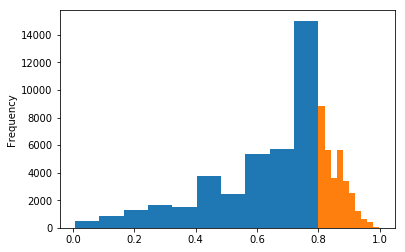

In [11]:
df_tn.prob.plot(kind='hist')
df_fp.prob.plot(kind='hist')

In [12]:
df_events[df_events.event_type == 'offline_receive_coupon'].head(5)

,date,date2,event_type,user_id,merchant_id,coupon_id,discount_name,distance,click_count
2239,2016-01-01,NaT,offline_receive_coupon,3916664,1169,2663,150:30,1.0,NaN
6539,2016-01-01,NaT,offline_receive_coupon,124779,6735,7496,95,0.0,NaN
7510,2016-01-01,NaT,offline_receive_coupon,2273636,4860,9704,100:20,1.0,NaN
7828,2016-01-01,NaT,offline_receive_coupon,6001356,398,1895,90,5.0,NaN
13085,2016-01-01,NaT,offline_receive_coupon,1340099,1815,4186,95,0.0,NaN


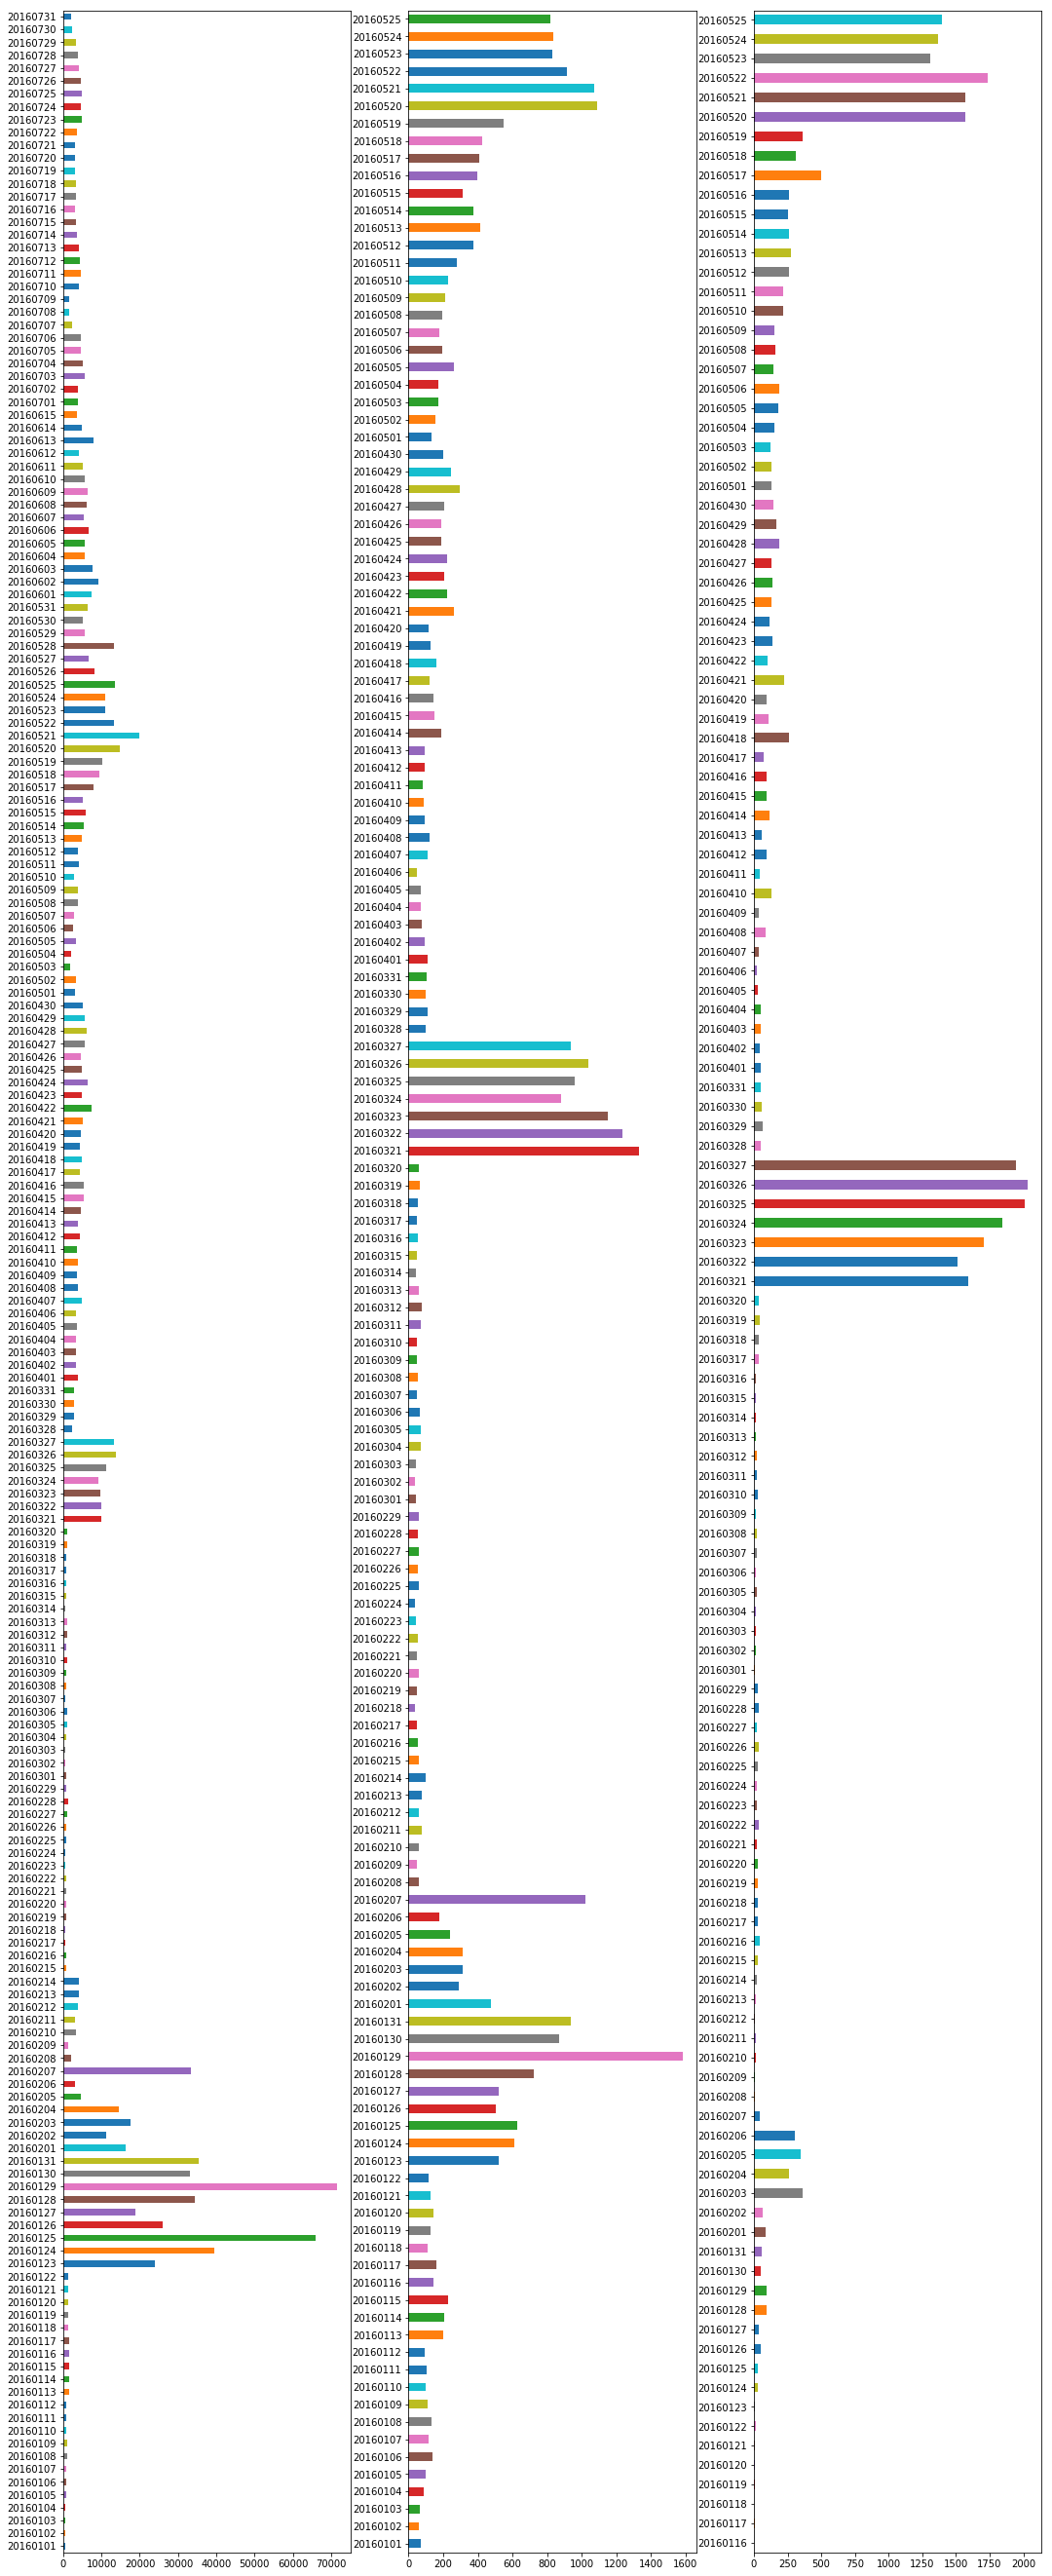

In [15]:
plt.figure(figsize=(18, 48))
plt.subplot(1, 3, 1)
df_events[df_events.event_type == 'offline_receive_coupon']\
    ['date'].dt.strftime('%Y%m%d').value_counts().sort_index().plot(kind='barh')
plt.subplot(1, 3, 2)
df_tn['date'].value_counts().sort_index().plot(kind='barh')
plt.subplot(1, 3, 3)
df_fp['date'].value_counts().sort_index().plot(kind='barh')

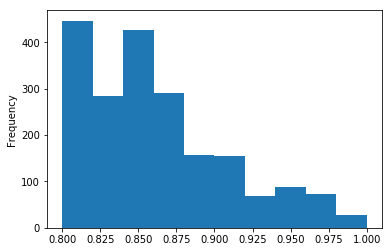

In [323]:
df_fp.prob.plot(kind='hist')

In [324]:
df_tn[(df_tn.prob > 0.495) & (df_tn.prob < 0.505)]
df_fp[(df_fp.prob > 0.49) & (df_fp.prob < 0.805)]

,user_id,coupon_id,date,label,prob
278,302713,104,20160526,False,0.802810
525,951942,14038,20160526,False,0.800203
748,41450,12852,20160526,False,0.801273
755,4414728,12852,20160526,False,0.800977
1068,5681861,12852,20160526,False,0.802606
1273,5230853,6643,20160526,False,0.800547
1881,4620979,104,20160526,False,0.803932
1889,2510571,11860,20160526,False,0.802172
1993,6674774,11085,20160526,False,0.800151
2541,3264882,6563,20160526,False,0.804856


In [325]:
# 951942	14038	20160526	False
df_events[df_events.user_id==951942]

,date,date2,event_type,user_id,merchant_id,coupon_id,discount_name,distance,click_count
2703710,2016-03-10,NaT,online_click,951942,24012,NaN,NaN,NaN,1.0
2703708,2016-03-28,NaT,online_click,951942,23206,NaN,NaN,NaN,2.0
2703711,2016-03-28,NaT,online_click,951942,51908,NaN,NaN,NaN,1.0
1177225,2016-05-02,NaT,offline_buy_without_coupon,951942,4321,NaN,NaN,4.0,NaN
68581,2016-05-04,NaT,offline_receive_coupon,951942,6388,2235,20:1,5.0,NaN
1177226,2016-05-07,NaT,offline_buy_without_coupon,951942,4321,NaN,NaN,4.0,NaN
68580,2016-05-07,NaT,offline_receive_coupon,951942,4321,5432,20:1,4.0,NaN
1177227,2016-05-26,NaT,offline_buy_without_coupon,951942,7119,NaN,NaN,0.0,NaN
68582,2016-05-26,NaT,offline_receive_coupon,951942,7119,14038,20:1,0.0,NaN
2248406,2016-06-06,NaT,online_buy_without_coupon,951942,15811,NaN,NaN,NaN,NaN


In [327]:
df_events[df_events.merchant_id==7119]['event_type'].value_counts()

offline_buy_without_coupon    19
offline_receive_coupon        13
offline_buy_with_coupon        2
online_receive_coupon          0
online_click                   0
online_buy_without_coupon      0
online_buy_with_coupon         0
Name: event_type, dtype: int64

In [326]:
df_events[df_events.coupon_id=='14038']['event_type'].value_counts()

offline_receive_coupon        13
offline_buy_with_coupon        2
online_receive_coupon          0
online_click                   0
online_buy_without_coupon      0
online_buy_with_coupon         0
offline_buy_without_coupon     0
Name: event_type, dtype: int64

In [196]:
df_train_full[df_train_full.user_id == 6028027].T

,883701,1023701
user_id,6028027,6028027
merchant_id,3621,3621
coupon_id,2705,4823
date,2016-05-23 00:00:00,2016-06-10 00:00:00
distance,0,0
discount_name,20:5,20:5
label,False,False
is_xianshi,False,False
is_dazhe,False,False
is_manjian,True,True


In [141]:
df_train = pd.read_msgpack('data/z4_merge_1.msgpack')
df_validate = pd.read_msgpack('data/z4_merge_2.msgpack')
df_test = pd.read_msgpack('data/z4_merge_3.msgpack')

In [142]:
dfs = dict(train=df_train, validate=df_validate, test=df_test)

In [143]:
raw_columns = [
    'user_id', 'merchant_id', 'coupon_id', 'discount_name',
    'date_received', 'date_received_name', 'date', 'date_name',
]
for df_name, df in dfs.items():
    columns = [x for x in raw_columns if x in df.columns]
    display_df_info(df[columns], df_name)

train 137167 rows


""


validate 258446 rows


""


test 113640 rows


""


In [63]:
column_isna = df_train.isna().any()
column_isna[column_isna]

merchant_offline_received_coupon_transfer_rate    True
merchant_offline_buy_with_coupon_transfer_rate    True
dtype: bool

In [74]:
df_train['merchant_offline_received_coupon_transfer_rate'].dtype

dtype('float64')

In [1]:
import lightgbm as lgb

/Users/kk/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [144]:
model = lgb.Booster(model_file='data/model-lgb-20190101-131937.dat')
model

In [163]:
items = list(zip(model.feature_name(), model.feature_importance()))
df = pd.DataFrame.from_records(items, columns=['feature', 'score'])
df = df.sort_values('score', ascending=False)
df

,feature,score
208,merchant_offline_transfer_rate_received_coupon...,168
272,user_offline_merchant_value_count_mean,129
42,discount_online_buy_with_coupon_user_usage_mean,121
158,merchant_offline_buy_without_coupon_user_nunique,104
58,distance_offline_buy_with_coupon_user_usage_max,103
160,merchant_offline_buy_without_coupon_user_usage...,90
209,user_offline_coupon_count,82
8,coupon_offline_received_coupon_user_count,81
55,distance,80
28,discount_man,75


In [ ]:
lgb.create_tree_digraph(model, 100)

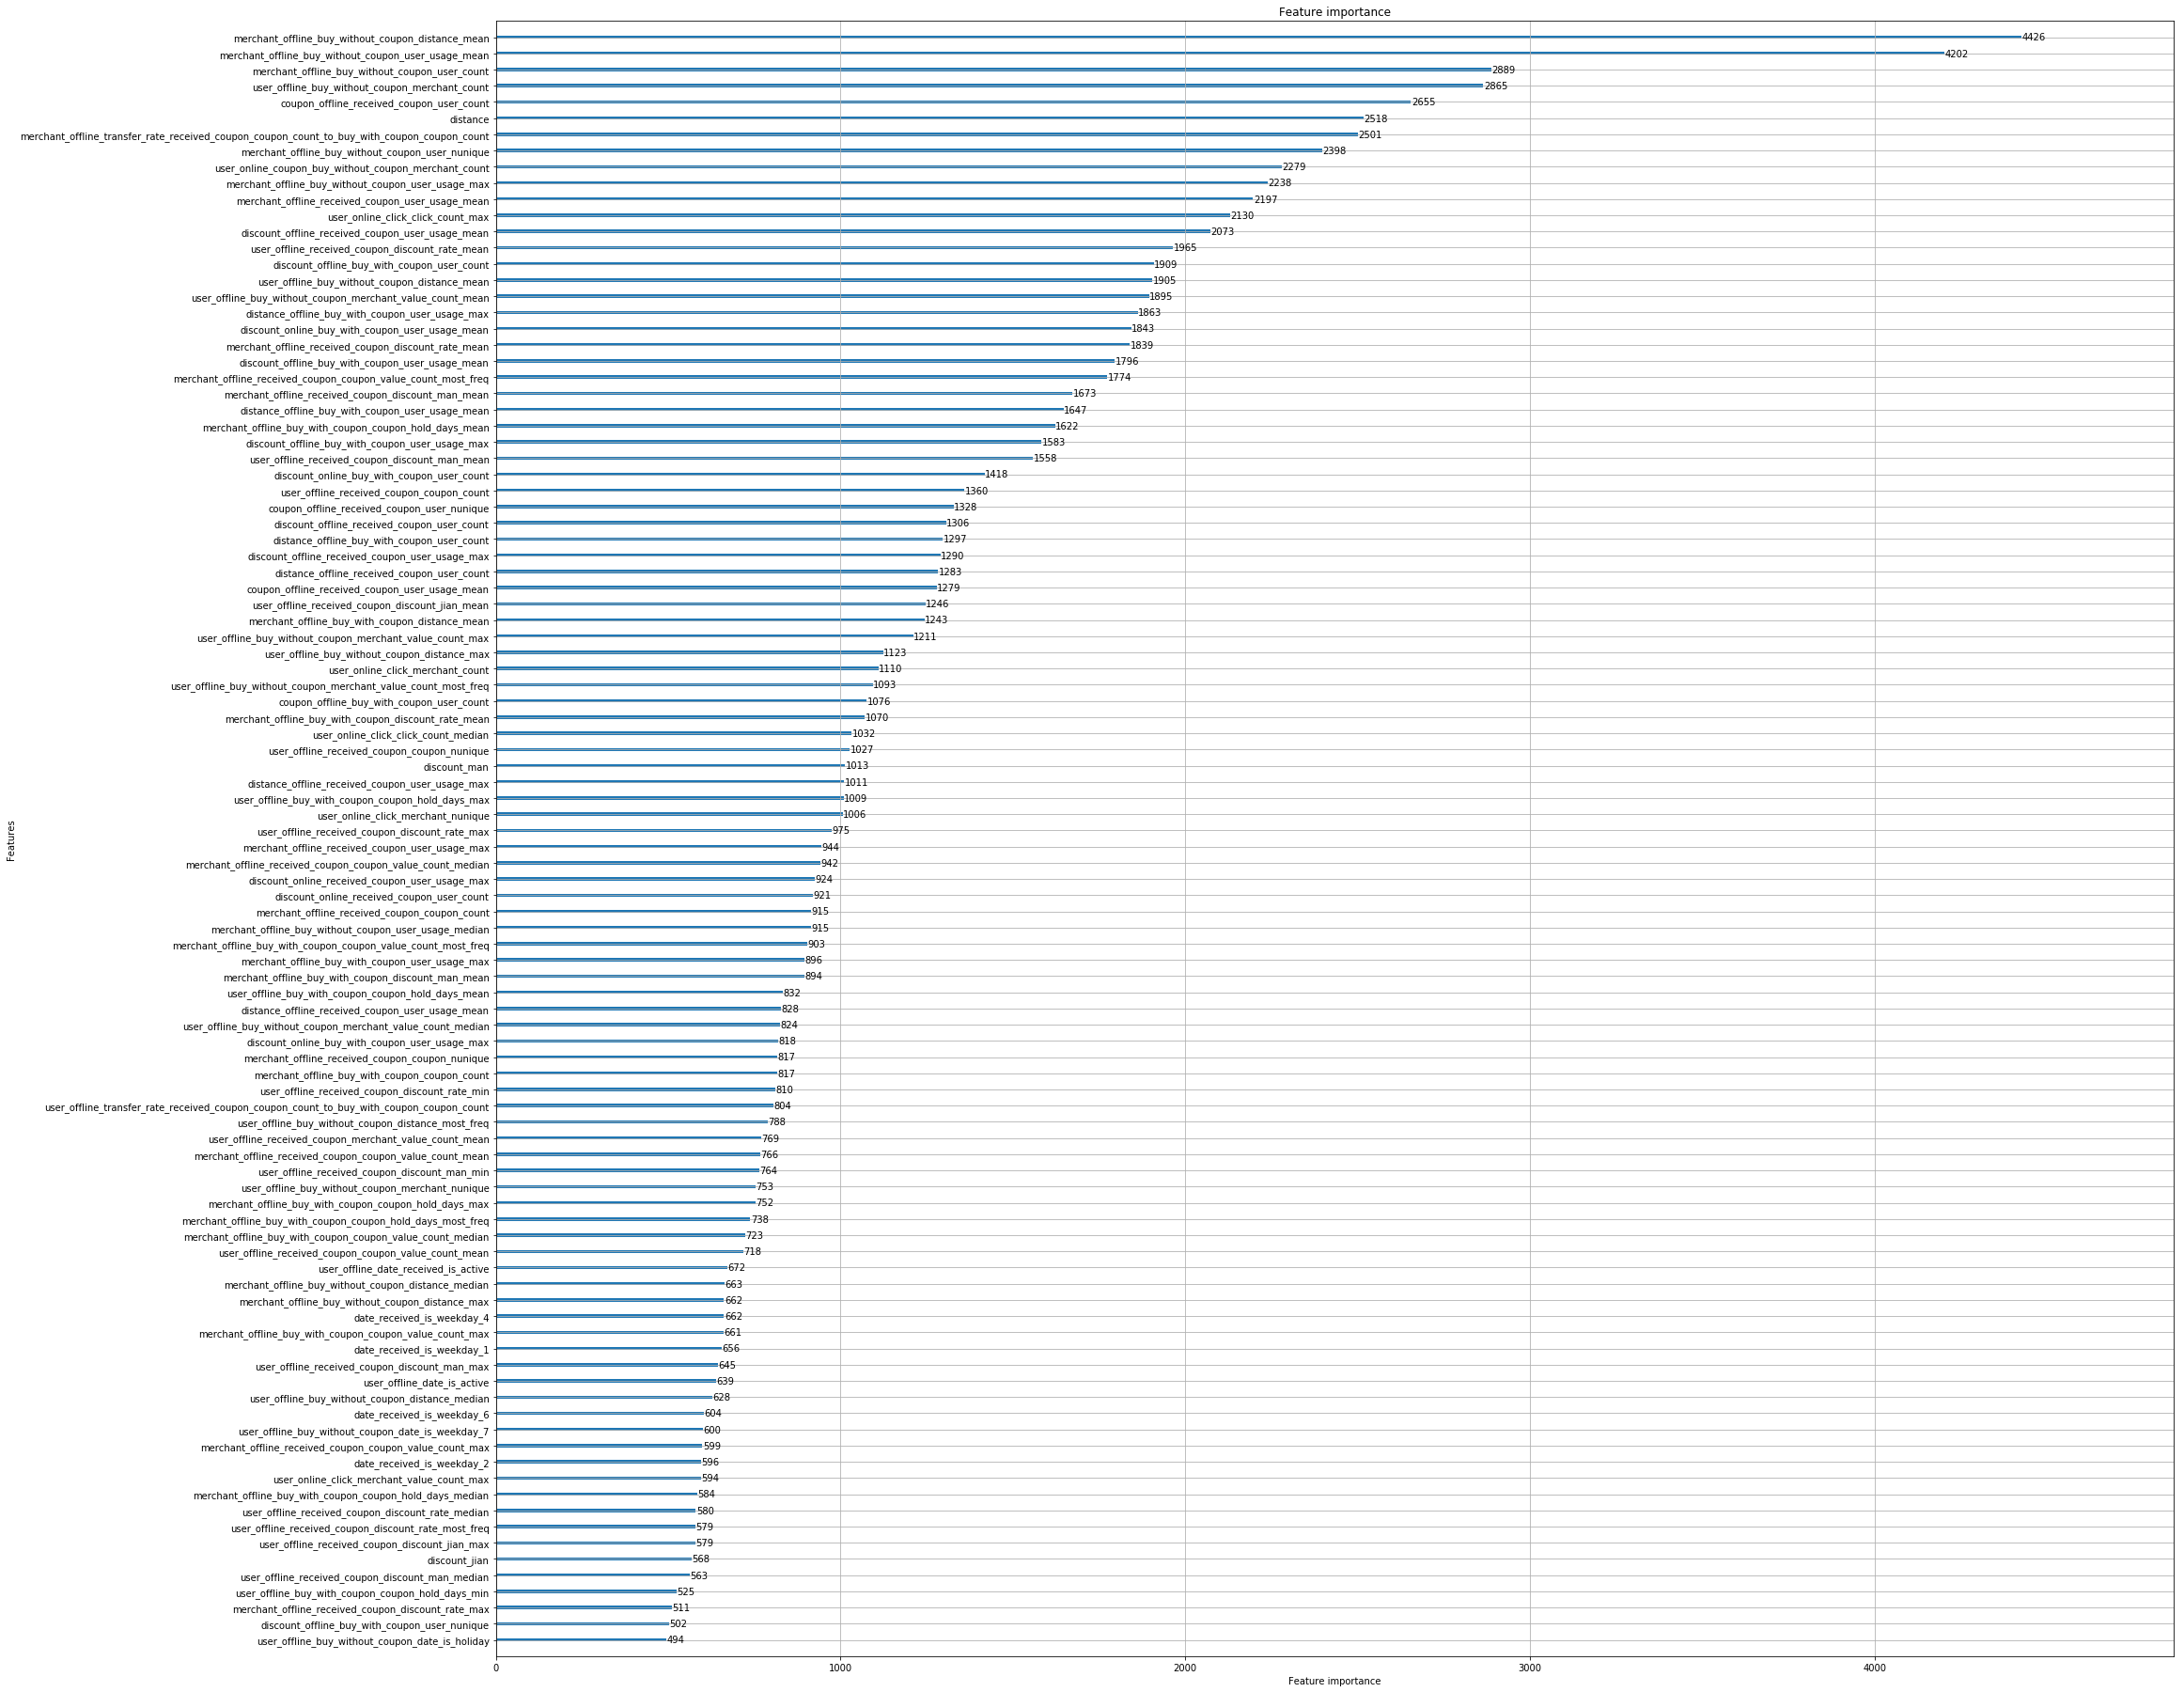

In [24]:
lgb.plot_importance(model, max_num_features=100, figsize=(32, 32))

In [7]:
stats = []
compares = [('train', 'validate'), ('train', 'test'), ('validate', 'test')]
for df_name, df_base_name in compares:
    for column in ['user_id', 'merchant_id', 'coupon_id']:
        df, df_base = dfs[df_name], dfs[df_base_name]
        if column in df.columns and column in df_base.columns:
            a = set(df[column].unique())
            b = set(df_base[column].unique())
            miss = b - a
            stats.append(( df_name, df_base_name, column, len(a), len(b), len(miss), len(miss) / len(b), list(miss)[:4] ))
stats = pd.DataFrame.from_records(stats)
stats.columns = ['dataframe', 'base_dataframe', 'column', 'total', 'base_total', 'num_miss', 'miss_ratio', 'miss']
stats

,dataframe,base_dataframe,column,total,base_total,num_miss,miss_ratio,miss
0,train,validate,user_id,234724,76257,40546,0.531702,"[4, 6553604, 786439, 1703951]"
1,train,validate,merchant_id,4878,2705,302,0.111645,"[6657, 514, 4, 2053]"
2,train,validate,coupon_id,7598,3348,874,0.261051,"[11249, 7614, 9646, 3094]"
3,train,test,user_id,234724,76309,29516,0.386796,"[6684672, 524296, 6946838, 4980766]"
4,train,test,merchant_id,4878,1559,242,0.155228,"[2053, 6, 8200, 1032]"
5,train,test,coupon_id,7598,2050,1251,0.610244,"[11249, 7614, 9306, 9646]"
6,validate,test,user_id,76257,76309,52206,0.684139,"[6684672, 262145, 1835014, 524296]"
7,validate,test,merchant_id,2705,1559,366,0.234766,"[4099, 6, 4105, 8202]"
8,validate,test,coupon_id,3348,2050,1063,0.518537,"[12000, 7440, 9306, 896]"


In [8]:
def split_column_name(name):
    if name in df_train.columns:
        dtype = df_train[name].dtype.name
    else:
        dtype = 'NA'
    parts = name.split('_', maxsplit=1)
    return parts[0], name, dtype

items = list(map(split_column_name, df_train.columns))
df = pd.DataFrame.from_records(items, columns=['prefix', 'name', 'dtype'])
df

,prefix,name,dtype
0,user,user_id,int64
1,merchant,merchant_id,int64
2,coupon,coupon_id,object
3,distance,distance,float64
4,date,date_received,datetime64[ns]
5,discount,discount_name,object
6,is,is_dazhe,bool
7,is,is_manjian,bool
8,discount,discount_man,float64
9,discount,discount_jian,float64


In [9]:
df.groupby(['prefix', 'dtype']).size().to_frame('count')

count
prefix   dtype                
coupon   float64            14
         object              1
date     bool               11
         datetime64[ns]      1
         object              1
discount float64            31
         object              1
distance float64             3
         int64              12
is       bool                2
label    bool                1
merchant float64            79
         int64               1
         object             44
user     float64           150
         int64               1
         object            104

In [146]:
from sklearn import feature_selection

def split_feature_label(df):
    df_x = df[df.columns.difference(['label'])]
    df_y = df['label']
    return df_x, df_y


df_train_x, df_train_y = split_feature_label(df_train)

In [165]:
df_validate_x, df_validate_y = split_feature_label(df_validate.sample(10000))

In [212]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True)
df_validate_x_2d = pca.fit_transform(df_validate_x, df_validate_y)
df_validate_x_2d = pd.DataFrame.from_records(df_validate_x_2d)
df_validate_x_2d.head(5)

,0,1
0,1.357043,0.262737
1,0.261843,0.380043
2,1.154565,-0.478048
3,-1.499994,0.681509
4,1.673078,-0.111967


In [140]:
df_validate_x.columns

Index(['coupon_offline_buy_with_coupon_user_count',
       'coupon_offline_buy_with_coupon_user_nunique',
       'coupon_offline_buy_with_coupon_user_usage_max',
       'coupon_offline_buy_with_coupon_user_usage_mean',
       'coupon_offline_buy_with_coupon_user_usage_median',
       'coupon_offline_buy_with_coupon_user_usage_min',
       'coupon_offline_buy_with_coupon_user_usage_most_freq',
       'coupon_offline_buy_with_coupon_user_usage_std',
       'coupon_offline_received_coupon_user_count',
       'coupon_offline_received_coupon_user_nunique',
       ...
       'user_online_coupon_discount_rate_most_freq',
       'user_online_coupon_discount_rate_std',
       'user_online_coupon_merchant_count',
       'user_online_coupon_merchant_nunique',
       'user_online_coupon_merchant_value_count_max',
       'user_online_coupon_merchant_value_count_mean',
       'user_online_coupon_merchant_value_count_median',
       'user_online_coupon_merchant_value_count_most_freq',
       'user_on

Text(0, 0.5, 'coupon_offline_received_coupon_user_count')

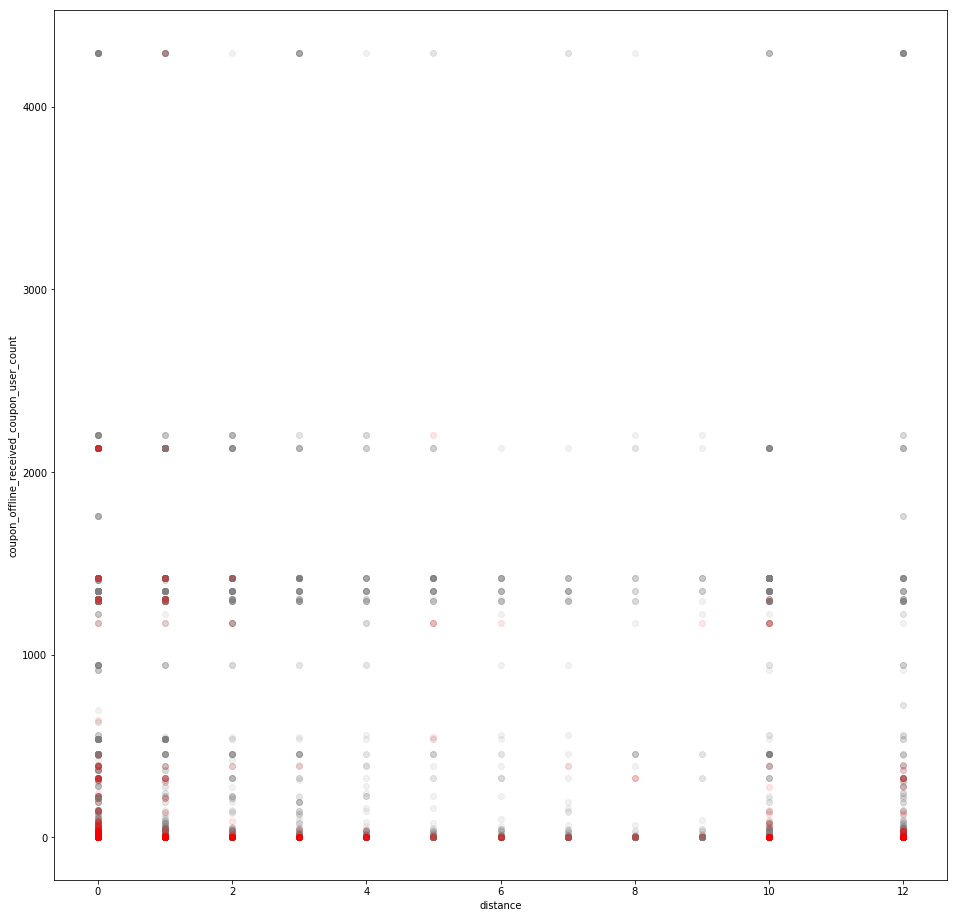

In [202]:
# x_col = 'merchant_offline_buy_without_coupon_user_usage'
# y_col = 'user_offline_buy_without_coupon_merchant_count'
# merchant_offline_transfer_rate_received_coupon...	168
# 272	user_offline_merchant_value_count_mean	129
# 42	discount_online_buy_with_coupon_user_usage_mean	121
# 158	merchant_offline_buy_without_coupon_user_nunique	104
# 58	distance_offline_buy_with_coupon_user_usage_max	103
# 160	merchant_offline_buy_without_coupon_user_usage...	90
# 209	user_offline_coupon_count	82
# 8	coupon_offline_received_coupon_user_count	81
# 55	distance	80
# 28	discount_man	75
# 0	coupon_offline_buy_with_coupon_user_count	71
# 222	user_offline_date_is_active

x_col = 'distance'
y_col = 'coupon_offline_received_coupon_user_count'
plt.figure(figsize=(16, 16))
# plt.xscale('symlog')
# plt.yscale('symlog')
colors = df_validate_y.map({True: 'red', False: 'grey'})
# marker = df_validate_y.map({True: 'x', False: 'o'})

x, y = df_validate_x[x_col], df_validate_x[y_col]

plt.scatter(x[~df_validate_y], y[~df_validate_y], c='grey', marker='o', alpha=0.1)
plt.scatter(x[df_validate_y], y[df_validate_y], c='r', marker='o', alpha=0.1)
plt.xlabel(x_col)
plt.ylabel(y_col)
# plt.scatter(df_validate_x[x_col], df_validate_x[y_col], c=colors, marker='x', alpha=0.5)


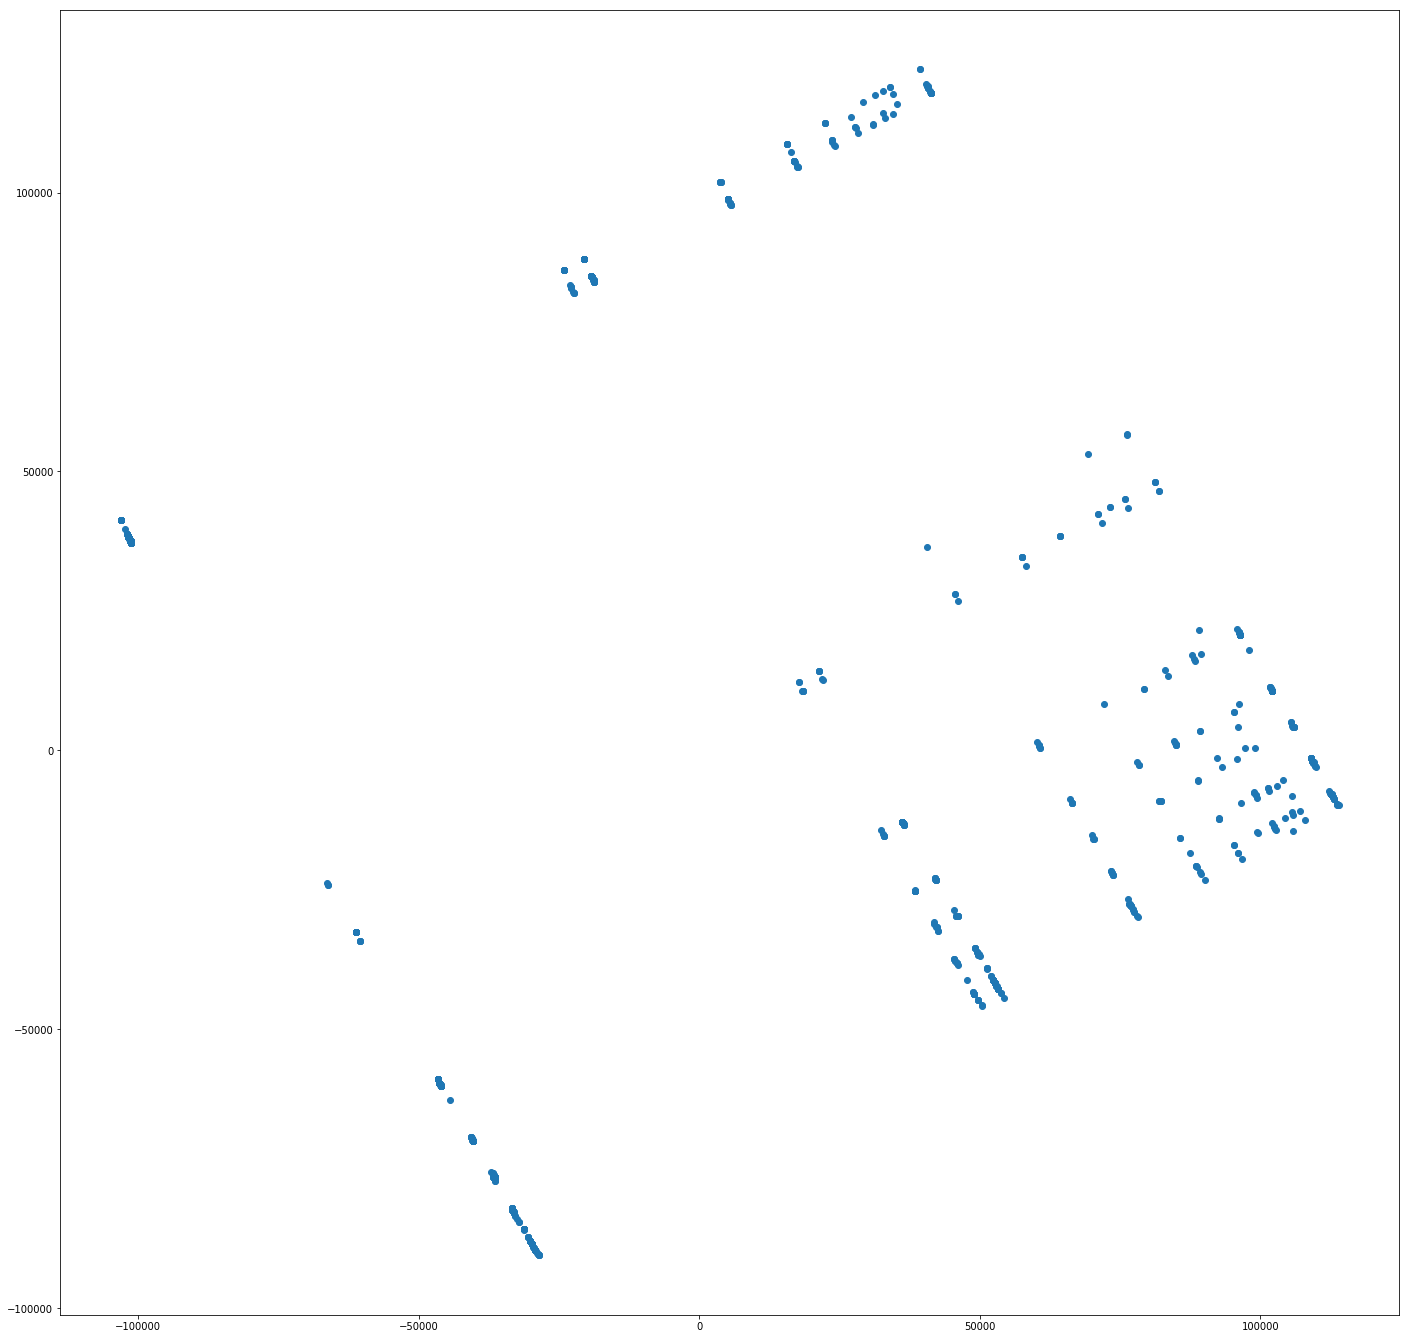

In [124]:
plt.figure(figsize=(24, 24))
# data = df_validate_x_2d.sample(1000)
plt.scatter(df_validate_x_2d[0], df_validate_x_2d[1])

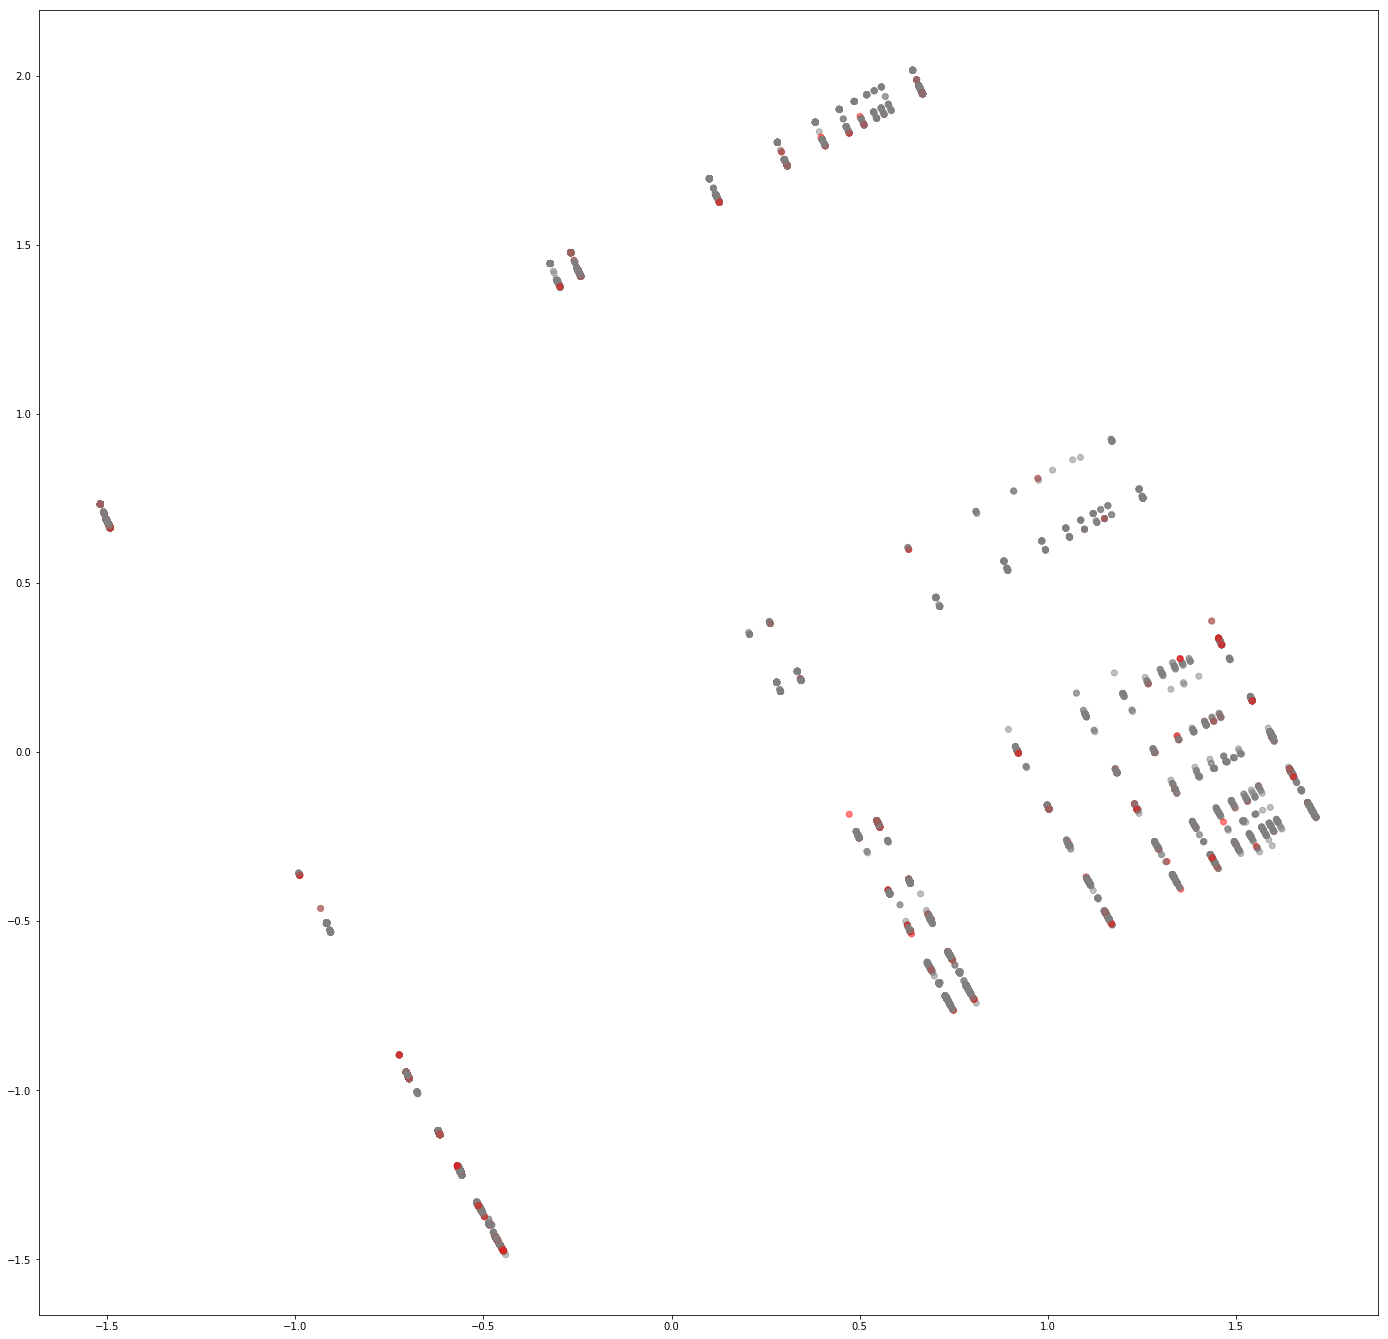

In [213]:
colors = df_validate_y.map({True: 'red', False: 'grey'})
plt.figure(figsize=(24, 24))
plt.scatter(df_validate_x_2d[0], df_validate_x_2d[1], c=colors, alpha=0.5)

In [114]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
df_validate_x_3d = pca.fit_transform(df_validate_x, df_validate_y)
df_validate_x_3d = pd.DataFrame.from_records(df_validate_x_3d)
df_validate_x_3d.head(5)

,0,1,2
0,16228.497331,22841.109112,21495.173663
1,49755.427082,-36629.516383,-7869.570570
2,-46044.150276,-60080.221273,-7272.626532
3,49761.856687,-36642.394307,-7868.613650
4,-101788.934735,38339.796561,-1090.939335


No handles with labels found to put in legend.


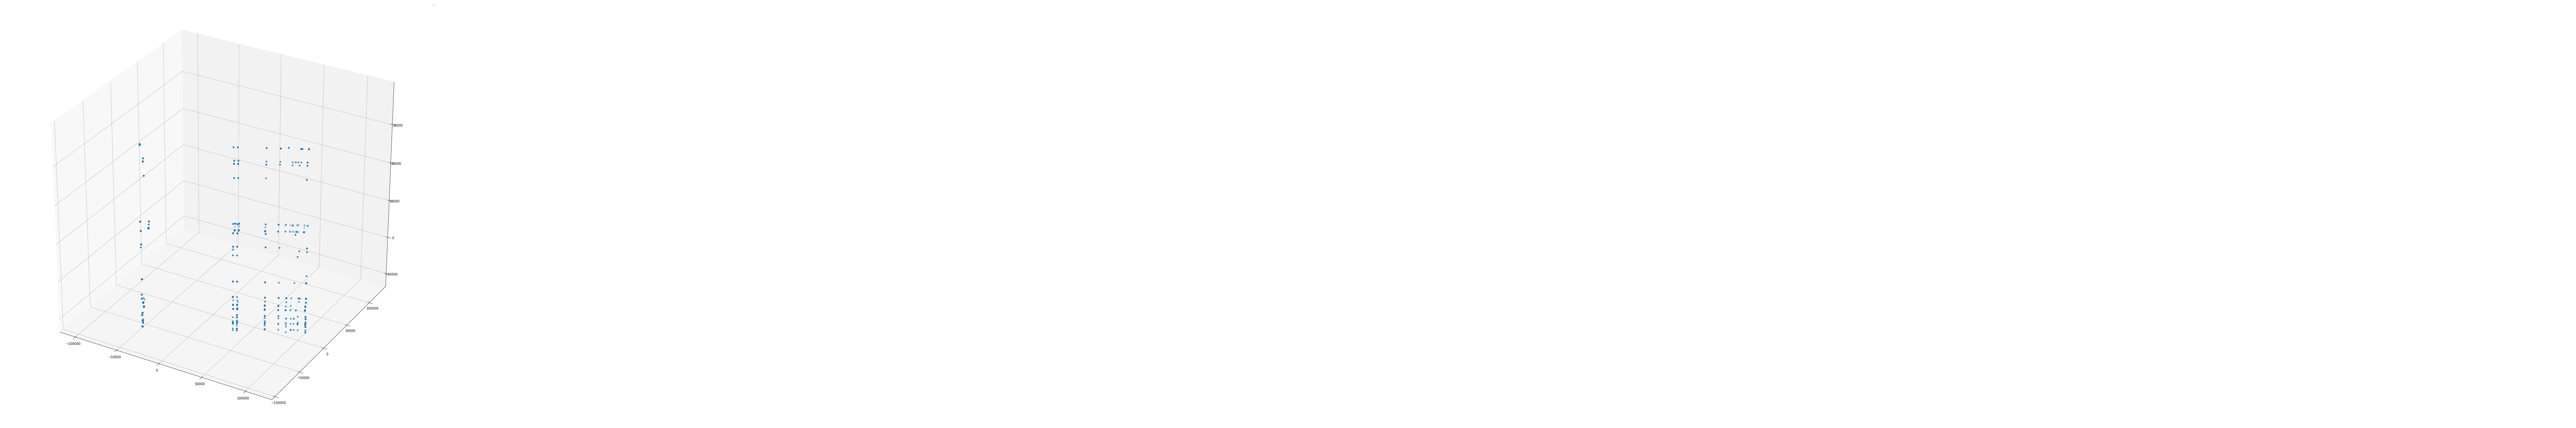

In [125]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(24, 24))
ax = fig.gca(projection='3d')
data = df_validate_x_3d.sample(1000)
ax.scatter(data[0], data[1], data[2])
plt.show()

No handles with labels found to put in legend.


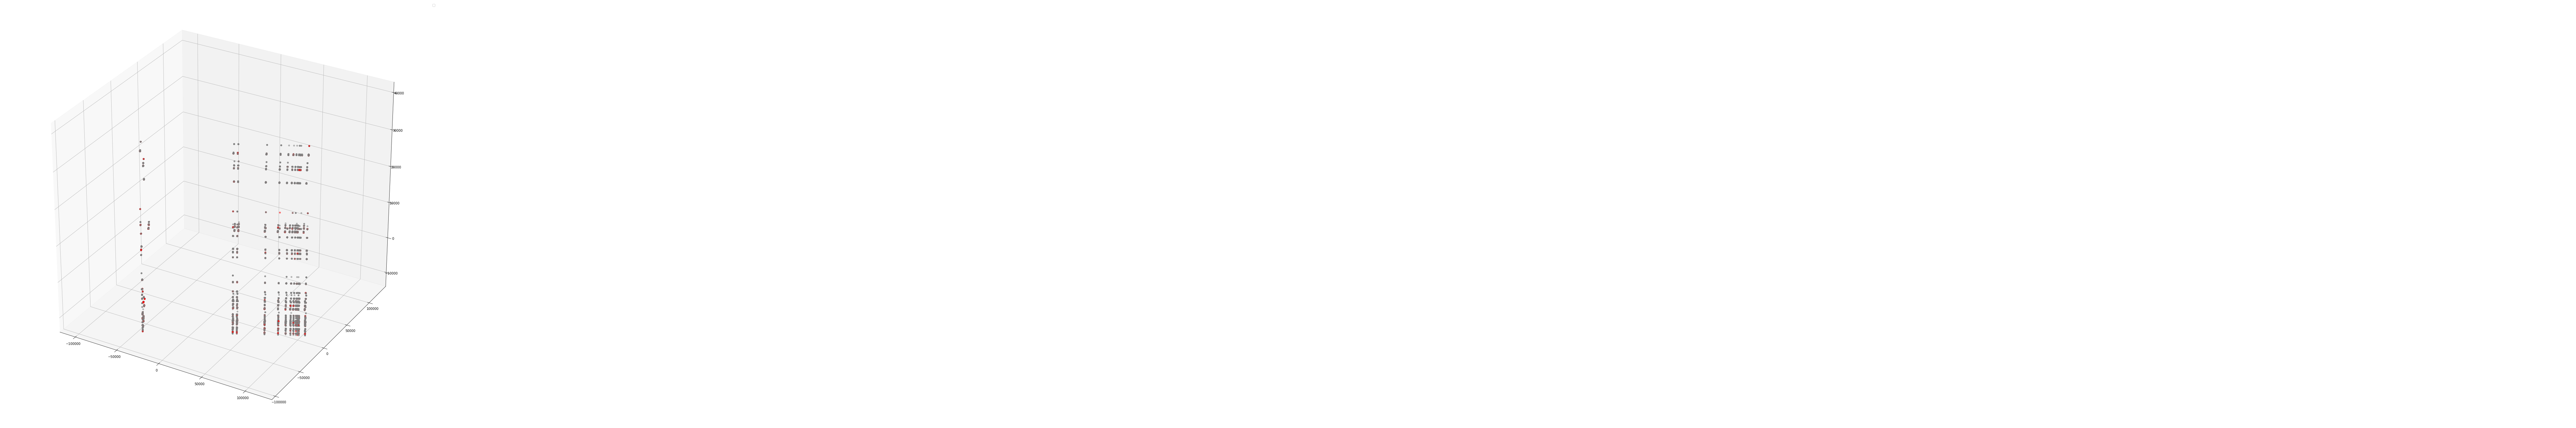

In [123]:
fig = plt.figure(figsize=(24, 24))
ax = fig.gca(projection='3d')

data = df_validate_x_3d
ax.scatter(data[0].values, data[1].values, data[2].values, c=colors, alpha=0.5)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [216]:
import os.path, sys
sys.path.insert(0, os.path.abspath('pipeline'))

import opensource_dataset as od

(134416, 52) (252481, 52) (112803, 52)


In [224]:
df_od_x = od.dataset12_x.fillna(0)
df_od_y = od.dataset12_y.fillna(0)
pca = PCA(n_components=2)
df_od_x_2d = pca.fit_transform(df_od_x, df_od_y)
df_od_x_2d.head(5)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [222]:
colors = df_od_y.map({True: 'red', False: 'grey'})
colors.value_counts()

grey    355355
red      31542
Name: label, dtype: int64

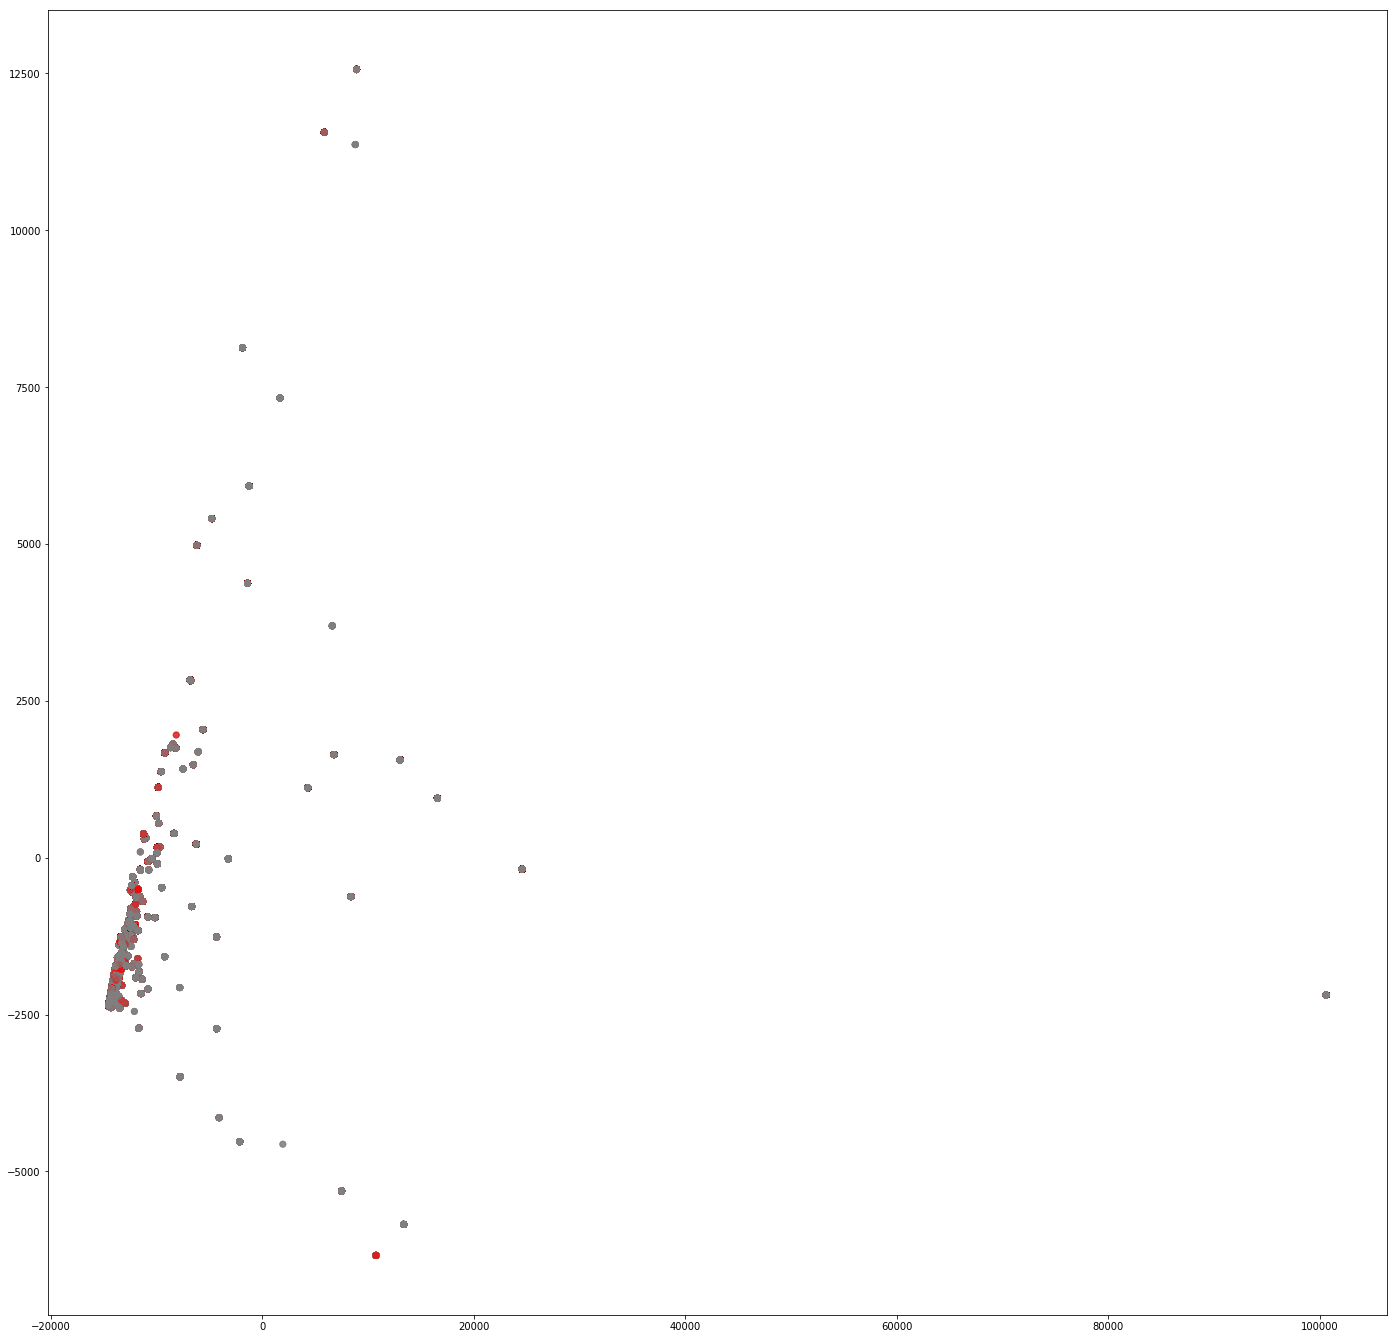

In [225]:
plt.figure(figsize=(24, 24))
plt.scatter(df_od_x_2d.T[0], df_od_x_2d.T[1], c=colors, alpha=0.5)

In [209]:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler


class ScalerPCA(TransformerMixin):
    def __init__(self, n_components=None):
        self._scaler = StandardScaler()
        self._pca = PCA(n_components=n_components, whiten=True)

    def fit(self, df_x, df_y):
        self.columns_ = list(df_x.dtypes[df_x.dtypes == np.dtype(float)].index)
        float_values = self._scaler.fit_transform(df_x[self.columns_].values, df_y.values)
        bool_values = df_x[df_x.columns.difference(self.columns_)].values
        values = np.concatenate((float_values, bool_values), axis=1)
        self._pca.fit(values, df_y.values)
        self.n_components_ = self._pca.n_components_
        return self

    def transform(self, df_x):
        float_values = self._scaler.transform(df_x[self.columns_].values)
        bool_values = df_x[df_x.columns.difference(self.columns_)].values
        values = np.concatenate((float_values, bool_values), axis=1)
        values = self._pca.transform(values)
        df_pca = pd.DataFrame.from_records(values)
        return df_pca


In [210]:
pca = ScalerPCA(n_components=2)
df_validate_x_2d = pca.fit_transform(df_validate_x, df_validate_y)
df_validate_x_2d.head(5)

,0,1
0,-0.131470,-0.131350
1,-0.484110,0.982952
2,-0.153011,1.729212
3,-0.531103,-0.596229
4,-0.073580,1.476422


In [231]:
df_validate_x.shape, df_validate_y.value_counts()

((10000, 373), False    9065
 True      935
 Name: label, dtype: int64)

In [247]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1)
df_validate_x_1d = lda.fit_transform(df_validate_x, df_validate_y)
df_validate_x_1d


/Users/kk/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


array([[-0.95919505],
       [ 1.61247716],
       [-0.21072583],
       ...,
       [ 0.86512557],
       [-0.08937866],
       [-0.36316224]])

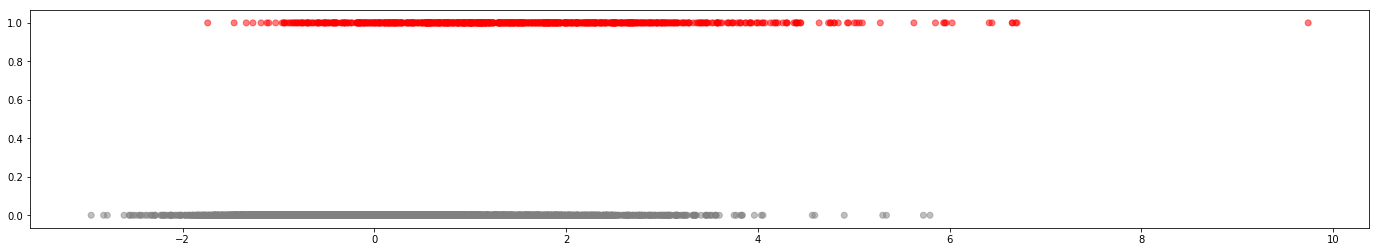

In [250]:
colors = df_validate_y.map({True: 'red', False: 'grey'})
plt.figure(figsize=(24, 4))
plt.scatter(df_validate_x_1d.T[0], df_validate_y, c=colors, alpha=0.5)

In [241]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1)
df_validate_x_1d = lda.fit_transform(df_od_x, df_od_y)
df_validate_x_1d


/Users/kk/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


array([[-0.64996653],
       [-1.10464114],
       [-1.19055614],
       ...,
       [-0.19018271],
       [-0.50442166],
       [-0.18825241]])

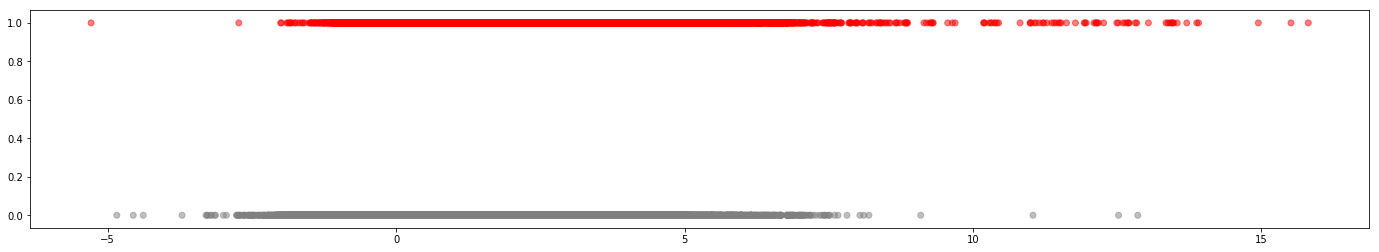

In [246]:
colors = df_od_y.map({True: 'red', False: 'grey'})
plt.figure(figsize=(24, 4))
plt.scatter(df_validate_x_1d.T[0], df_od_y, c=colors, alpha=0.5)

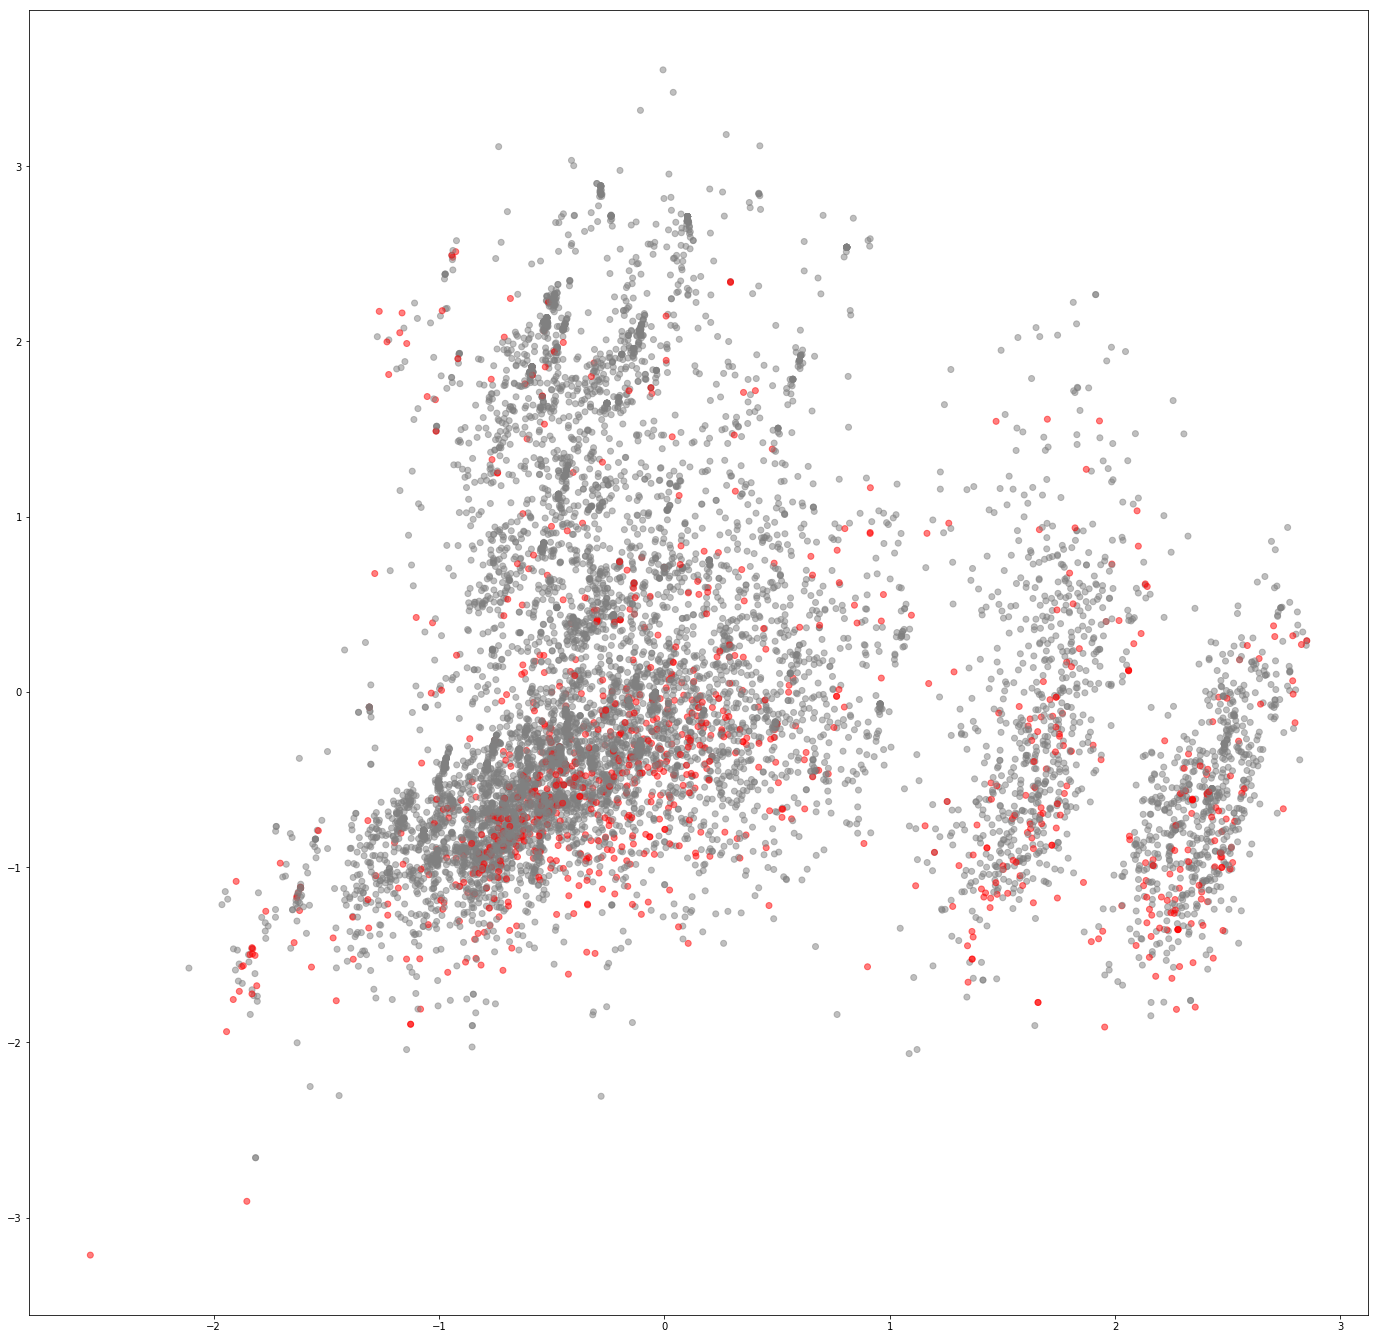

In [211]:
plt.figure(figsize=(24, 24))
plt.scatter(df_validate_x_2d[0], df_validate_x_2d[1], c=colors, alpha=0.5)

In [130]:
pca = ScalerPCA(n_components=3)
df_validate_x_3d = pca.fit_transform(df_validate_x, df_validate_y)
df_validate_x_3d.head(5)

,0,1,2
0,3.016744,-7.822267,6.310365
1,1.139448,-4.273994,5.345117
2,2.153397,2.632819,3.101191
3,-9.140382,-3.073696,-0.444371
4,2.871934,2.579358,-4.634300


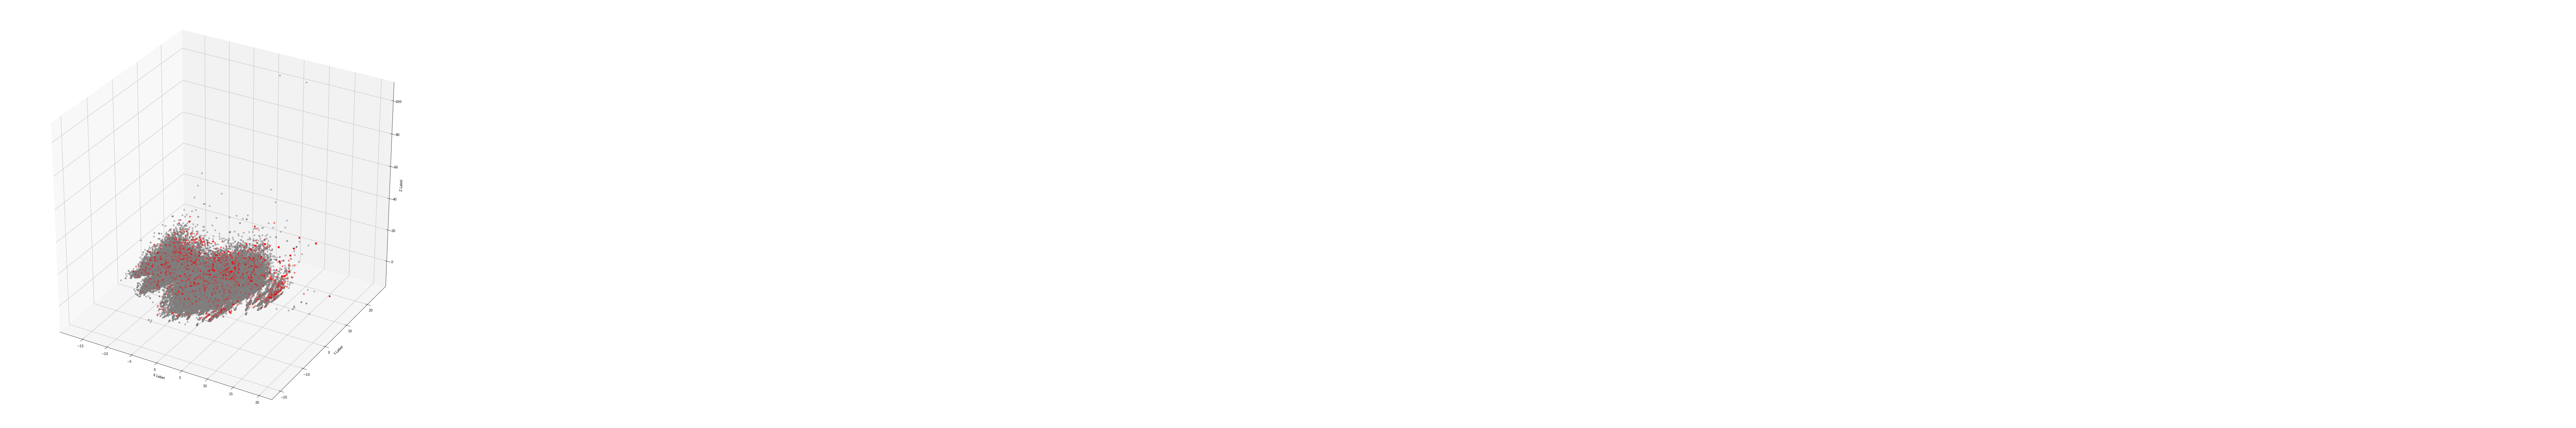

In [131]:
fig = plt.figure(figsize=(24, 24))
ax = fig.gca(projection='3d')

data = df_validate_x_3d
ax.scatter(data[0].values, data[1].values, data[2].values, c=colors, alpha=0.5)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()


In [36]:
df_offline = pd.read_msgpack('data/z1_raw_offline.msgpack')
df_online_coupon = pd.read_msgpack('data/z1_raw_online_coupon.msgpack')
df_online_click = pd.read_msgpack('data/z1_raw_online_click.msgpack')
df_test = pd.read_msgpack('data/z1_raw_test.msgpack')

In [37]:
display_df_info(df_offline)

 1754884 rows


,column,dtype,max,memory_usage,min,num_null,num_unique
0,user_id,int64,7361032,14.04 MB,4,0,539438
1,merchant_id,int64,8856,14.04 MB,1,0,8415
2,coupon_id,object,7610,14.04 MB,10779,701602,9738
3,distance,float64,10,14.04 MB,0,106003,11
4,date_received,datetime64[ns],2016-06-15 00:00:00,14.04 MB,2016-01-01 00:00:00,701602,167
5,date,datetime64[ns],2016-06-30 00:00:00,14.04 MB,2016-01-01 00:00:00,977900,182
6,discount_name,object,30:5,14.04 MB,150:5,701602,45
7,is_dazhe,bool,True,1.75 MB,False,0,2
8,is_manjian,bool,True,1.75 MB,False,0,2
9,discount_man,float64,300,14.04 MB,0,701602,10


In [50]:
df_offline['id'] = np.arange(len(df_offline))
display_df_info(df_offline)

df_online_coupon['id'] = np.arange(len(df_online_coupon))
display_df_info(df_online_coupon)

df_online_click['id'] = np.arange(len(df_online_click))
display_df_info(df_online_click)

df_test['id'] = np.arange(len(df_test))
display_df_info(df_test)

 1754884 rows


,column,dtype,max,memory_usage,min,num_null,num_unique
0,user_id,int64,7361032,14.04 MB,4,0,539438
1,merchant_id,int64,8856,14.04 MB,1,0,8415
2,coupon_id,object,7610,14.04 MB,10779,701602,9738
3,distance,float64,10,14.04 MB,0,106003,11
4,date_received,datetime64[ns],2016-06-15 00:00:00,14.04 MB,2016-01-01 00:00:00,701602,167
5,date,datetime64[ns],2016-06-30 00:00:00,14.04 MB,2016-01-01 00:00:00,977900,182
6,discount_name,object,30:5,14.04 MB,150:5,701602,45
7,is_dazhe,bool,True,1.75 MB,False,0,2
8,is_manjian,bool,True,1.75 MB,False,0,2
9,discount_man,float64,300,14.04 MB,0,701602,10


 2028046 rows


,column,dtype,max,memory_usage,min,num_null,num_unique
0,user_id,int64,15499999,16.22 MB,4,0,482945
1,merchant_id,int64,60000,16.22 MB,10001,0,7963
2,coupon_id,object,fixed,16.22 MB,100151025,1155689,27747
3,date_received,datetime64[ns],2016-06-15 00:00:00,16.22 MB,2016-01-01 00:00:00,1155689,167
4,date,datetime64[ns],2016-06-30 00:00:00,16.22 MB,2016-01-01 00:00:00,655898,182
5,discount_name,object,fixed,16.22 MB,800:500,1155689,64
6,is_xianshi,bool,True,2.03 MB,False,0,2
7,is_dazhe,bool,False,2.03 MB,False,0,1
8,is_manjian,bool,True,2.03 MB,False,0,2
9,discount_man,float64,1000,16.22 MB,5,1287235,12


 4380240 rows


,column,dtype,max,memory_usage,min,num_null,num_unique
0,user_id,int64,15500000,35.04 MB,36,0,585710
1,merchant_id,int64,60000,35.04 MB,10001,0,7999
2,date,datetime64[ns],2016-06-30 00:00:00,35.04 MB,2016-01-01 00:00:00,0,182
3,count,int64,630,35.04 MB,1,0,232
4,id,int64,4380239,35.04 MB,0,0,4380240


 113640 rows


,column,dtype,max,memory_usage,min,num_null,num_unique
0,user_id,int64,7361024,909.12 KB,209,0,76309
1,merchant_id,int64,8856,909.12 KB,6,0,1559
2,coupon_id,object,9998,909.12 KB,100,0,2050
3,distance,float64,10,909.12 KB,0,12064,11
4,date_received,datetime64[ns],2016-07-31 00:00:00,909.12 KB,2016-07-01 00:00:00,0,31
5,discount_name,object,95,909.12 KB,100:1,0,42
6,is_dazhe,bool,True,113.64 KB,False,0,2
7,is_manjian,bool,True,113.64 KB,False,0,2
8,discount_man,int64,500,909.12 KB,0,0,11
9,discount_jian,float64,100,909.12 KB,1,2566,7


In [51]:
import featuretools as ft

es = ft.EntitySet()
es.entity_from_dataframe(
    'offline', df_offline, 
    index='id', time_index='date_received')
es.entity_from_dataframe(
    'online_coupon', df_online_coupon, 
    index='id', time_index='date_received')
es.entity_from_dataframe(
    'online_click', df_online_click, 
    index='id', time_index='date')
es.entity_from_dataframe(
    'test', df_test, 
    index='id', time_index='date_received')
es

Entityset: None
  Entities:
    offline [Rows: 1754884, Columns: 14]
    online_coupon [Rows: 2028046, Columns: 13]
    online_click [Rows: 4380240, Columns: 5]
    test [Rows: 113640, Columns: 12]
  Relationships:
    No relationships

In [59]:
s = pd.Series([True, False, None]).to_frame('x')['x']
s.nunique()

2

In [161]:
df = pd.DataFrame.from_records([[1,2,3], [8,9,6], [7,8,9]], columns=['x', 'y', 'z'])
df['x'] = df['x'].astype('category')
df['y'] = df['y'].astype('category')
df

,x,y,z
0,1,2,3
1,8,9,6
2,7,8,9


In [162]:
dfm = df.set_index(['x', 'y'])
dfm

,,z
x,y,
1,2,3
8,9,6
7,8,9


In [163]:
df.dtypes

x    category
y    category
z       int64
dtype: object

In [170]:
y_idx = dfm.index.get_indexer?
y_idx
# y_idx.intersection([1])

CategoricalIndex([2, 9, 8], categories=[2, 8, 9], ordered=False, name='y', dtype='category')

Signature: dfm.index.get_indexer(target, method=None, limit=None, tolerance=None)
Docstring:
Compute indexer and mask for new index given the current index. The
indexer should be then used as an input to ndarray.take to align the
current data to the new index.

Parameters
----------
target : MultiIndex or list of tuples
method : {None, 'pad'/'ffill', 'backfill'/'bfill', 'nearest'}, optional
    * default: exact matches only.
    * pad / ffill: find the PREVIOUS index value if no exact match.
    * backfill / bfill: use NEXT index value if no exact match
    * nearest: use the NEAREST index value if no exact match. Tied
      distances are broken by preferring the larger index value.
limit : int, optional
    Maximum number of consecutive labels in ``target`` to match for
    inexact matches.
tolerance : optional
    Maximum distance between original and new labels for inexact
    matches. The values of the index at the matching locations most
    satisfy the equation ``abs(index[indexe

In [173]:
dfm.loc[2]

KeyError: 'the label [2] is not in the [index]'